# Recurrent text gen

This notebook considers building model that generate text using RNN architecture.

In [ ]:
import json
import tqdm
import pprint
import kagglehub
import numpy as np
import pandas as pd
from random import sample
import matplotlib.pyplot as plt
from tempfile import TemporaryDirectory 

import torch
from torch import nn

import huggingface_hub
hf_api = huggingface_hub.HfApi()

from pathlib import Path
files_path = Path("recurrent_text_gen_files")
files_path.mkdir(exist_ok=True)

path = kagglehub.dataset_download("Cornell-University/arxiv/versions/205")
path = Path(path)/"arxiv-metadata-oai-snapshot.json"

/home/f.kobak@maxbit.local/Documents/knowledge/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data

*arxiv* dataset will be used. As this notebook follows only educational puposes we'll take relatevely small data subset.

In [2]:
data_path = files_path/"arxiv_small.json"

if not data_path.exists():
    
    LINES = []
    with open(path, "r") as f:
        for i, one_line in enumerate(tqdm.tqdm(f.readlines())):
            if i % 10 == 0:
                LINES.append(one_line)

    with open(data_path, mode="w") as f:
        f.writelines(LINES)

data = pd.read_json(data_path, lines=True)

Data preparation can be divided into several stages:

- Adding BOS and EOS tokens to each text, marking the beginning and end of the text, respectively.  
- Splitting texts into tokens: each symbol will be treated as a separate token to reduce the total number of tokens.  
- Encoding tokens numerically. From this step, we can store the data as a `torch.Tensor`. However, PyTorch requires all rows in tensors to be the same size, so we’ll pad the data with indices corresponding to `EOS`.

The following cell defines `BOS` (beggining of sentence) and `EOS` (end of sentence) tokens and adds them to each observation in the sample. As a result, we've got a `LINES` list that will be used as a data source throughout the notebook.

In [3]:
BOS, EOS = " ", "\n"
LINES = (
    data
    .apply(lambda row: (row["title"] + " ; " + row["abstract"])[:512], axis=1)
    .apply(lambda line: BOS + line.replace(EOS, " ") + EOS)
    .tolist()
)

LINES[:3]

[' Calculation of prompt diphoton production cross sections at Tevatron and   LHC energies ;   A fully differential calculation in perturbative quantum chromodynamics is presented for the production of massive photon pairs at hadron colliders. All next-to-leading order perturbative contributions from quark-antiquark, gluon-(anti)quark, and gluon-gluon subprocesses are included, as well as all-orders resummation of initial-state gluon radiation valid at next-to-next-to-leading logarithmic accuracy. The region o\n',
 ' Computing genus 2 Hilbert-Siegel modular forms over $\\Q(\\sqrt{5})$ via   the Jacquet-Langlands correspondence ;   In this paper we present an algorithm for computing Hecke eigensystems of Hilbert-Siegel cusp forms over real quadratic fields of narrow class number one. We give some illustrative examples using the quadratic field $\\Q(\\sqrt{5})$. In those examples, we identify Hilbert-Siegel eigenforms that are possible lifts from Hilbert eigenforms. \n',
 ' Molecular Syn

The following code finds all available letters in the dataset under consideration and saves them into the `TOKENS` list.

In [4]:
TOKENS = {one_char for one_line in LINES for one_char in one_line}

TOKENS = sorted(TOKENS)
"".join(TOKENS)

'\n !"#$%&\'()*+,-./0123456789:;<=>?@ABCDEFGHIJKLMNOPQRSTUVWXYZ[\\]^_`abcdefghijklmnopqrstuvwxyz{|}~\x7f\x80\x99â'

The following cell defines the `TOKEN_TO_ID` dictionary that corresponds to the index of each token. And a `TO_TENSOR` function that can transform an array of texts into the `Torch.Tensor`.

In [5]:
TOKEN_TO_ID = {x: i for i, x in enumerate(TOKENS)}

def to_tensor(
    lines: list[str],
    max_len: int | None = None,
    pad: str = TOKEN_TO_ID[EOS],
    dtype: torch.dtype = torch.int64,
) -> torch.Tensor:
    '''
    Turns a list of texts into a torch tensor. Each text in `lines` will form a 
    row in the output tensor.

    Parameters
    ----------
    lines: list[str]
        Array of the text that needed to be transformed into tensors.
    max_len: int | None = None
        Maximum length considered by the function. It defines the number of 
        columns in the output. If not specified the length of the lonest
        element in `lines` will be used. Any text that is not long enough 
        will be padded.
    pad: str
        Token that must be used to pad texts that does not have enough length.
    dtype: torch.dtype
        Type of data that'll be used in the output tensors
    
    Returns
    -------
    out: torch.Tensor
        `lines` that transformed into `torch.Tensor`.
    '''

    max_len = max_len or max(map(len, lines))
    lines_ix = torch.full([len(lines), max_len], pad, dtype=dtype)
    for i in range(len(lines)):
        line_ix = [TOKEN_TO_ID[x] for x in lines[i][:max_len]]
        lines_ix[i, : len(line_ix)] = torch.tensor(line_ix)
    return lines_ix

So finally we have a procedure that allows to transform a list of texts into `torch.tensor`, the following cell shows how it can be used:

In [6]:
print(to_tensor([" abc\n", " abacaba\n", " abc1234567890\n"]))

tensor([[ 1, 66, 67, 68,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 1, 66, 67, 66, 68, 66, 67, 66,  0,  0,  0,  0,  0,  0,  0],
        [ 1, 66, 67, 68, 18, 19, 20, 21, 22, 23, 24, 25, 26, 17,  0]])


## Model form

In this section, we'll consider a computational procedure that is realized in the model.

As an example, consider the inputs defined in the following cell:

In [7]:
inp = to_tensor(["sentence 1 hi", "sentence 2 wow"])
emb_size = 16
hidden_size = 10

First of all, for all tokens we will build embeddings of the dimension specified in `emb_size`.

In [8]:
emb = nn.Embedding(num_embeddings=len(TOKENS), embedding_dim=emb_size)
embeded = emb(inp)
embeded.shape

torch.Size([2, 14, 16])

In our case, for each text we get a matrix containing a 16-dimensional vector for each token in that text.

Then each sentence is transformed by RNN into a sequence of states with the chosen `hidden_state`.

In [9]:
rnn = nn.RNN(input_size=emb_size, hidden_size=hidden_size)
states = rnn(embeded)[0]
states.shape

torch.Size([2, 14, 10])

Finally, linear layer for each token "unzips" hidden states into vector where there is numer that corresponds to each token we work with.

In [10]:
linear = nn.Linear(in_features=hidden_size, out_features=len(TOKENS))
linear(states).shape

torch.Size([2, 14, 100])

The entire complex of transformations is encapsulated in the class defined in the next cell:

In [10]:
class RNNLanguageModel(nn.Module):
    '''
    The model predicts the provability of the next token for each token in the 
    array for tokens.

    Parameters
    ----------
    n_tokens: int
        The number of unique tokens the model should work with.
    emb_size: int = 16
        Size of the encoding that each token is encoded as.
    hid_size: int = 256
        Dimensionality of the hidden state in the RNN layer.    
    '''

    def __init__(
        self, 
        n_tokens: int, 
        emb_size: int = 16, 
        hid_size: int = 256
    ) -> None:
        super().__init__()
        self.emb = nn.Embedding(num_embeddings=n_tokens, embedding_dim=emb_size)
        self.rnn = nn.RNN(emb_size, hid_size, batch_first=True)
        self.linear = nn.Linear(in_features=hid_size, out_features=n_tokens)

    def forward(self, input_ix: torch.Tensor) -> torch.Tensor:
        rv: torch.Tensor = self.emb(input_ix)
        rv: torch.Tensor = self.rnn(rv)[0]
        rv: torch.Tensor = self.linear(rv)
        return rv
    
model = RNNLanguageModel(len(TOKENS))
model(inp).shape

torch.Size([2, 14, 100])

## Loss

Loss, in my opinion, is a very tricky part of such models. Although it is just a modification of the really typical corssentropy, there are some problems with this model.


The loss formula is as follows:

$$
L = - \cfrac{1}{N} \sum_{i=1}^N \ln p(x_t^{(i)} | x_{t-1}^{(i)}, \dots, x_1^{(i)})
$$

Next, let's try to deconstruct its intuition and implementation peculiarities in torch.

We'll pass a sequence of tokens to our network. To predict the $t$-th token, we need to pass all the previous $t-1$ tokens. The result will be the probabilities for each token to be the $t$-th token.

$p(x_t^{(i)} | x_{t-1}^{(i)}, \dots, x_1^{(i)})$: this represents the probability that the $t$-th token follows the previous $t-1$ tokens, as predicted by the model. We want the probability of the true token to be as high as possible, so our goal can be achieved by minimizing $L$.

We'll consider the procedure on the set of texts and model defined in the following cell.

In [11]:
inp = to_tensor(["Some long input to the model", "short"])
model = RNNLanguageModel(len(TOKENS), hid_size=3)

We should compare the outputs of the model for each token with the next token in the same sentnce. To achieve this:

- The last token of each input is skipped - we don't have a target value for it anyway.
- The first token of the output is skipped, we can't predict it because there is no context for it.

In [13]:
rnn_input = inp[:, :-1]
display(rnn_input[:, :-1])
reference_answers = inp[:, 1:]
display(reference_answers)

tensor([[52, 80, 78, 70,  1, 77, 80, 79, 72,  1, 74, 79, 81, 86, 85,  1, 85, 80,
          1, 85, 73, 70,  1, 78, 80, 69],
        [84, 73, 80, 83, 85,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0]])

tensor([[80, 78, 70,  1, 77, 80, 79, 72,  1, 74, 79, 81, 86, 85,  1, 85, 80,  1,
         85, 73, 70,  1, 78, 80, 69, 70, 77],
        [73, 80, 83, 85,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0]])

As a result, the input and output sequences are shifted so that each token in the input corresponds to the next token in the output.

The softmax function is applied to the results of the model to give them probability properties that are important for cross-entropy. 

In [14]:
logits = model(rnn_input)
probas = torch.softmax(logits, 2)
real_probas = torch.gather(probas, 2, reference_answers[..., None]).squeeze(2)
real_probas

tensor([[0.0106, 0.0087, 0.0081, 0.0082, 0.0207, 0.0070, 0.0022, 0.0062, 0.0087,
         0.0085, 0.0043, 0.0246, 0.0097, 0.0057, 0.0090, 0.0044, 0.0040, 0.0054,
         0.0044, 0.0096, 0.0078, 0.0084, 0.0069, 0.0037, 0.0071, 0.0099, 0.0110],
        [0.0086, 0.0086, 0.0046, 0.0053, 0.0120, 0.0074, 0.0073, 0.0073, 0.0073,
         0.0073, 0.0073, 0.0073, 0.0073, 0.0073, 0.0073, 0.0073, 0.0073, 0.0073,
         0.0073, 0.0073, 0.0073, 0.0073, 0.0073, 0.0073, 0.0073, 0.0073, 0.0073]],
       grad_fn=<SqueezeBackward1>)

There is another problem - paddings. They are only used to make the recurrent layers work properly on the data samples, but the model shouldn't care about the correctness of the predictions for them. To avoid this, we'll build a pass that marks tokens that really match some inputs as `true`, but marks padded tokens as `false`. The following cell shows code that achieves such a goal:

In [15]:
eos_ix = TOKEN_TO_ID[EOS]
mask = torch.nn.functional.pad(
    torch.cumsum(inp == eos_ix, dim=-1)[..., :-1] < 1,
    pad=(1, 0, 0, 0),
    value=True
)
mask

tensor([[ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False]])

It searches for the first occurrence of the `EOS` token, all subsequent tokens are padded.

Finally, a truly typical cross-entropy formula that uses a mask to make the padded components zero in the sum.

In [16]:
-torch.sum(torch.log(real_probas) * mask[:, 1:]) / inp.shape[0]

tensor(78.6129, grad_fn=<DivBackward0>)

The following code defines everything we've thought of so far as convenient, out-of-the-box functions.

In [17]:
def compute_mask(
    input_ix: torch.Tensor, 
    eos_ix: str = TOKEN_TO_ID[EOS]
) -> torch.Tensor:
    '''
    Compute a boolean mask that identifies real tokens as true and padded tokens
    as false. Works under the assumption that all tokens following the EOS token
    are padding.

    Paramters
    ---------
    input_ix: torch.Tensor
        Tensor of encoded tokens.
    eos_ix: int
        Index of the EOF token.

    Returns
    -------
    out: torch.Tensor
        Mask.
    '''
    return torch.nn.functional.pad(
        torch.cumsum(input_ix == eos_ix, dim=-1)[..., :-1] < 1,
        pad=(1, 0, 0, 0),
        value=True,
    )

def compute_loss(
    model: RNNLanguageModel, 
    input_ix: list[str], 
    device: torch.device = torch.device("cpu")
) -> torch.Tensor:
    '''
    Computes the cross-entropy loss of the given model in the given tensor of 
    encoded tokens.

    Parametrs
    ---------
    model: RNNLanguageModel
        Model that requires loss.
    input_ix: list[str]
        Set of data that is used to compute loss.
    device: torch.device = torch.device("cpu")
        Device that is used by model.

    Returns
    -------
    out: torch.Tensor
        0 dimensional tensor representing the loss value.
    '''
    input_ix = torch.as_tensor(input_ix, dtype=torch.int64)
    input_ix = input_ix.to(device)

    logits = model(input_ix[:, :-1])
    reference_answers = input_ix[:, 1:]
    rv = torch.softmax(logits, dim=-1)
    rv = torch.gather(rv, 2, reference_answers[:, :, None]).squeeze(2)
    rv = torch.log(rv)

    rv = rv * compute_mask(input_ix)[:, 1:]
    return -torch.sum(rv) / input_ix.shape[0]

Tools from the previous cell may be lost to the calculation.

In [18]:
compute_loss(model=model, input_ix=inp)

tensor(78.6129, grad_fn=<DivBackward0>)

## Generation

Our model, as it stands, predicts a vector representing the probabilities of the next token. However, to generate text, we need to predict a sequence of tokens. The idea is straightforward: predict the next token based on the tokens previously predicted by the model itself, invoking the model as many times as needed for our purposes.

Each time we obtain a vector $\left(p_1, p_2, \dots, p_n\right)$, there are various strategies for selecting the most appropriate token based on this vector. A detailed overview of these strategies warrants a separate page. Here, we implement the most popular one: random selection with temperature. High temperature smooths differences between all $p_i$, thereby increasing the probability of selecting tokens with lower probabilities. It makes model more creating but can reduce quality.

---

The following cell defines `generate` function that realises generation for the given model.

In [12]:
def generate(
    model: RNNLanguageModel,
    prefix: str = BOS,
    max_len: int = 100,
    device: torch.device = torch.device("cpu"),
    temperature: float = 1.
) -> str:
    '''
    Function generates text using given model.

    Parameters
    ----------
    model: RNNLanguageModel
        Model that have to be used for predictions.
    prefix: str = BOS
        Line from which we'll generate outcomes.
    max_len: int = 100
        Maximum length of the generated result.
    device:
        Device that is used by model.
    temperature: float = 1.
        Temperature of the model. If 0 is selected, the deterministic approach 
        is used - only the token with the higher predicted probability is 
        selected.

    Returns
    -------
    out: str
        Predicted text.
    '''
    
    with torch.no_grad():
        for i in range(max_len):
            logits = model(to_tensor([prefix]).to(device))[0, -1]
            probs = torch.softmax(logits, dim=-1).detach().numpy()

            if temperature == 0:
                next_token = TOKENS[np.argmax(probs)]
            else:
                probs = probs ** (1./temperature)
                probs /= sum(probs)
                next_token = np.random.choice(TOKENS, p=probs)

            prefix += next_token
            if next_token == EOS:
                break
    
    return prefix

Here is an example how this function can be used.

In [13]:
generate(RNNLanguageModel(len(TOKENS)), prefix="test line")

'test lineYKEtd<wV\x7f E14,H\x80#g\x80Q=,;G\n'

## Training

Training loop really typical, except for `nn.utils.clip_grad_norm_` - this is needed due to peculiarities of recurrent layers.

In [ ]:
torch.manual_seed(10)
device = "cuda" if torch.cuda.is_available() else "cpu"

epochs = 3000
clip_norm = 1e5
batch_size = 64
opt = torch.optim.Adam(model.parameters())

train_history = []
examples = []

model.to(device)
for i in tqdm.trange(len(train_history), epochs):
    batch = to_tensor(sample(LINES, batch_size)).to(device)
    loss_i = compute_loss(model, batch, device=device)

    opt.zero_grad()
    loss_i.backward()
    nn.utils.clip_grad_norm_(model.parameters(), clip_norm)
    opt.step()

    train_history.append((i, float(loss_i)))

    if (i + 1) % 50 == 0:
        examples.append(generate(model, device=device))


with TemporaryDirectory() as tmpdir:
    torch.save(model.state_dict(), Path(tmpdir)/"rec_text_gen.pth")
    hf_api.upload_folder(
        repo_id="fedorkobak/knowledge",
        folder_path=tmpdir
    )

(files_path/"examples.json").write_text(json.dumps(examples))
(files_path/"train_history.json").write_text(json.dumps(train_history))

Here is a plot of the train curve.

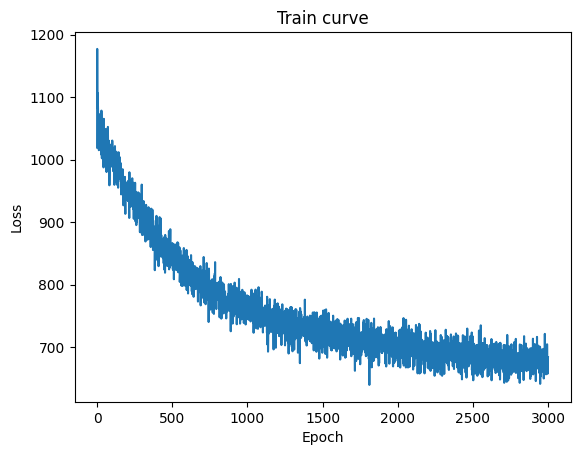

In [46]:
train_history = json.loads((files_path/"train_history.json").read_text())

plt.plot(*zip(*train_history))
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train curve")
plt.show()

Here you can see how the model gradually improves during the fitting process.

In [55]:
examples = json.loads((files_path/"examples.json").read_text())
for i in [1, 5, 10, 20, -10, -1]:
    print("="*80)
    print(examples[i])

 W3i0 probuin the. it frov of Boted Modiiticale as of meland incourbattoriinax ,ffensior, in the meun
 String inemped of the from dSepine of the anfinoments of a bathen 2mN$}$. A mended toprkied The\rage
 Fabraic 1ME$r'{\M}^{02}4,,$.]W ;   Tups ;   We low curburabures structure constroator mu

 Oxhered by the didronamination viable coonduptious for zis over (T).5 cluss and nenalated propotions
 Stractly the spin and Highstly or-the exploiting the remequation as  of generalized by multi-phase l
 Leall EOffodiate and Wave and on surface of the vanism problems collisions. In inequality: In tunste


## Text generation

The following cell represents how created model can be loaded.

In [70]:
file_path = huggingface_hub.hf_hub_download(
    repo_id="fedorkobak/knowledge", 
    filename="rec_text_gen.pth"
)
model = RNNLanguageModel(len(TOKENS))
_ = model.load_state_dict(torch.load(file_path, weights_only=False))

And cell where you can try generations of the model

In [71]:
ans = generate(model=model, prefix="Some input", temperature=0.8, max_len=500)
pprint.pprint(ans)

('Some input and cross conditions ;   The shear spectrostars. A solution '
 'theory consented it is a fundamental geometries with the challenges a '
 'Competing spin system of the felliable are abservation, which set of average '
 'group processes and an equivalent intemator Thic are theory propagiant '
 'characterize the finite the fraction for the numerical spin end Yirmovenco '
 'images of the incompanied to method various of semayn state. Completing '
 'fraument, of the thin problem to determine nots on corpling of the space: ')
